# Plot EKE map of southern ocean and evolution in areas defined by Patara (2016)

In [72]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from glob import glob
import numpy as np
from cmocean import cm
import cartopy.feature as cfeature
import matplotlib.colors as colors
import scipy.interpolate as sci
import matplotlib.ticker as mticker
from matplotlib import axes
from scipy.interpolate import NearestNDInterpolator, interp2d, griddata, LinearNDInterpolator, RegularGridInterpolator

import warnings
warnings.simplefilter('ignore')

### Load data

In [2]:
path_eke_base = '/scratch/usr/shkifmmp/master/data/ORION10/EKE/base/'
path_eke_nest = '/scratch/usr/shkifmmp/master/data/ORION10/EKE/nest/'
path_barot = '/scratch/usr/shkifmmp/master/data/ORION10/EKE/barotropic_sf/'

mask_path = '/scratch/usr/shkifmmp/master/data/ORION10/mask/'
mask_nest = xr.open_mfdataset(glob(mask_path + '1_mesh_mask.nc')).tmask.isel(z=0).squeeze()
mask_base = xr.open_mfdataset('/scratch/usr/shklvn09/NUDATA/ORION/10-data/meshmask/mesh_mask.nc').tmask.isel(z=0).squeeze()

In [68]:
mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/mask/mask_nest_int_2d.nc', chunks={"y":100, "x":100})

In [13]:
mask = xr.open_dataset(mask_path + 'mask_nest_int_2d.nc')

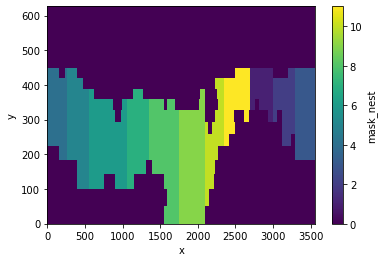

In [14]:
mask.mask_nest.plot()

In [8]:
mask 

<xarray.Dataset>
Dimensions:    (y: 627, x: 3562)
Coordinates:
    nav_lon    (y, x) float64 ...
    nav_lat    (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    mask_nest  (y, x) float64 ...

In [11]:
mask = mask.where(((mask==0) & (mask.nav_lon >= -85) & (mask.nav_lon <= 75)), other=1)

In [ ]:
#/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT

In [3]:
# EKE _1 (nest); _b (base)
eke_1 = xr.open_mfdataset(glob(path_eke_nest + '1_O*EKE*'), chunks={'y': 100, 'x': 100}).vozocrtx.where(mask_nest)
eke_1 = eke_1.squeeze().reset_coords(['depthu'], drop=True)

In [6]:
eke_1

<xarray.DataArray 'vozocrtx' (time_counter: 60, y: 629, x: 3564)>
dask.array<getitem, shape=(60, 629, 3564), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-07-02T12:00:00 ... 2017-...
    nav_lon       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_x_velocity
    long_name:           Sea Water X Velocity
    units:               m/s
    online_operation:    average
    interval_operation:  400 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 400 s) time_counter: mean

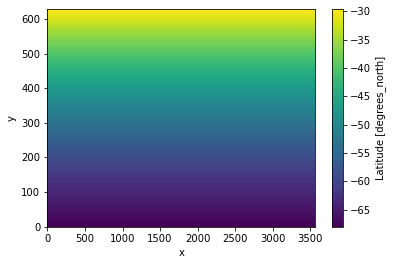

In [7]:
eke_1.nav_lat.plot()

In [3]:
eke_b = xr.open_mfdataset(glob(path_eke_base + 'O*EKE*.nc'), chunks={'y': 100, 'x': 100}).vozocrtx.where(mask_base)

eke_b = eke_b.squeeze().reset_coords(['depthu'], drop=True)

In [4]:
lon = xr.open_mfdataset(glob(path_eke_base + 'O*EKE*.nc')[0], chunks={'y': 100, 'x': 100}).nav_lon.where(mask_base)

In [5]:
# Barotropic streamfunction
path_sf = '/scratch/usr/shkifmmp/master/data/ORION10/EKE/barotropic_sf/'
b_sf = xr.open_mfdataset(glob(path_sf + 'O*streamfunc*nc')).sobarstf.where(mask_base).squeeze().reset_coords(['time_counter'], drop=True)

In [6]:
b_sf = b_sf/1e6 # to get in Sverdrup

In [ ]:
# eke_b.nav_lon.plot()

In [ ]:
# eke_b.isel(time_counter=0).plot()

### Correcting discontinuity of lon

In [ ]:
# eke_1.nav_lon.plot()

In [7]:
# eke_1.coords["x"] = range(len(eke_1.x))
# eke_1.coords["y"] = range(len(eke_1.y))

eke_b.coords["x"] = range(len(eke_b.x))
eke_b.coords["y"] = range(len(eke_b.y))

In [8]:
# after_discont_1 = ~(eke_1.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

after_discont_b = ~(eke_b.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

In [10]:
eke_1.coords["nav_lon"] = (
    eke_1.coords["nav_lon"]
    + 360 * after_discont_1
)

In [9]:
eke_b.coords["nav_lon"] = (
    eke_b.coords["nav_lon"]
    + 360 * after_discont_b
)

In [ ]:
# eke_b.isel(time_counter=0, y=slice(1,None)).plot()

In [ ]:
# eke_b.isel(y=slice(1,None)).nav_lat.values

In [10]:
# cropping redundant data
# eke_1 = eke_1.isel(x=slice(1,-1), y=slice(1,-1))
eke_b = eke_b.isel(y=slice(1,None), x=slice(1,None))

In [11]:
b_sf = b_sf.isel(y=slice(1,None), x=slice(1,None))#, x=slice(1,None))

In [12]:
b_sf.coords['nav_lat'] = eke_b.coords['nav_lat']

b_sf.coords['nav_lon'] = eke_b.coords['nav_lon']

In [13]:
# mean for the plots
# eke_1_m = eke_1.sel(time_counter=slice('2000','2017')).mean('time_counter').compute()

eke_b_m = eke_b.mean('time_counter').compute()

In [14]:
eke_b_m

<xarray.DataArray 'vozocrtx' (y: 510, x: 721)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    nav_lon  (y, x) float64 73.5 74.0 74.5 75.0 75.5 ... 433.0 433.0 433.0 433.0
    nav_lat  (y, x) float32 -76.9 -76.9 -76.9 -76.9 ... 50.12 50.02 50.0 50.02
  * x        (x) int64 1 2 3 4 5 6 7 8 9 ... 713 714 715 716 717 718 719 720 721
  * y        (y) int64 1 2 3 4 5 6 7 8 9 ... 502 503 504 505 506 507 508 509 510

In [16]:
lon = lon.isel(y=slice(1,None), x=slice(1,None))

In [17]:
eke_b_m = eke_b_m.assign_coords(lon=(("y", "x"), lon.nav_lon.values))

In [ ]:
# eke_b.isel(x=slice(1,None)).nav_lon.values

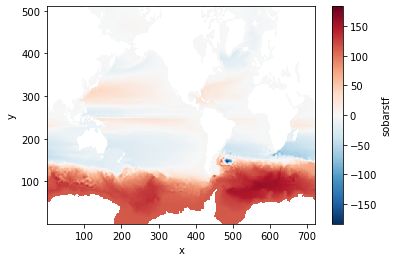

In [222]:
b_sf.plot()

In [184]:
(eke_b_m * 1e4).max().values

array(4496.90722656)

# Plot 2000-2017 mean

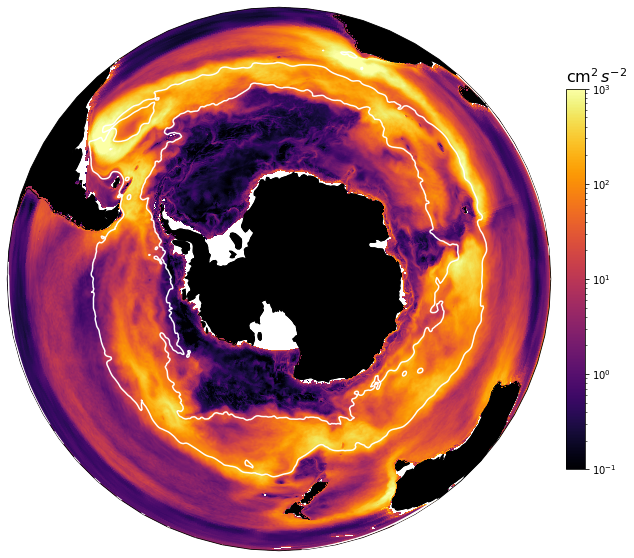

In [236]:
fig, axs = plt.subplots(figsize=(14,10), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

map1 = (eke_1_m * 1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3, 
               add_colorbar=False, norm = colors.LogNorm(vmin=1e-1, vmax=1e3), cmap= 'inferno')

(eke_b_m * 1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False, norm = colors.LogNorm(vmin=1e-1, vmax= 1e3), #vmax=(eke_1_m * 1e4).max().values),
                               cmap = 'inferno')

axs.contour(b_sf.nav_lon,b_sf.nav_lat, b_sf, transform= ccrs.PlateCarree(),
            colors='white', levels=[5, 110], linewidth=4, zorder=7)

c = plt.colorbar(map1, pad=0.02, shrink=0.7, ax=axs)
c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=16)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='k')

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
plt.savefig(save_path + 'EKE_temporalmean_2000_2017_inf.png', format='png', facecolor="w",  bbox_inches='tight')

### creating mask for time series

In [15]:
# smoothing the EKE and psi data before - 2 degrees
smoother_eke = LinearNDInterpolator(list(zip(eke_b_m.nav_lon.values.flatten(), eke_b_m.nav_lat.values.flatten())), eke_b_m.values.flatten())

In [16]:
smoother_psi = LinearNDInterpolator(list(zip(b_sf.nav_lon.values.flatten(), b_sf.nav_lat.values.flatten())), b_sf.values.flatten())

In [17]:
lon_sm = np.arange(74, 435, 2) #74, 437, 2
lat_sm = np.arange(-77, 90, 2)

lon_sm, lat_sm = np.meshgrid(lon_sm, lat_sm)

In [18]:
eke_smoothed = smoother_eke(lon_sm, lat_sm)

psi_smoothed = smoother_psi(lon_sm, lat_sm)

In [39]:
psi_b_smo

<xarray.DataArray 'psi_smoo' (y: 84, x: 181)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan, -4.19484448, -4.14177416, ..., -4.06119975,
        -4.24418379, -4.13949497],
       [        nan, -2.8065095 , -2.88569104, ..., -2.68730638,
        -2.74689011, -2.72032388],
       [        nan,         nan,         nan, ..., -1.88782092,
        -1.87306332, -1.85531631]])
Coordinates:
    nav_lon  (y, x) int64 74 76 78 80 82 84 86 ... 422 424 426 428 430 432 434
    nav_lat  (y, x) int64 -77 -77 -77 -77 -77 -77 -77 ... 89 89 89 89 89 89 89
Dimensions without coordinates: y, x

In [166]:
lon.isel(y=200).nav_lon[212].values

array(179.5, dtype=float32)

In [20]:
eke_b_smo = xr.Dataset(
    data_vars=dict(
        eke_smoo=(['y','x'], eke_smoothed)),
    coords=dict(
        nav_lon=(['y','x'], lon_sm),
        nav_lat=(['y','x'], lat_sm)))

psi_b_smo = xr.Dataset(
    data_vars=dict(
        psi_smoo=(['y','x'], psi_smoothed)),
    coords=dict(
        nav_lon=(['y','x'], lon_sm),
        nav_lat=(['y','x'], lat_sm)))

eke_b_smo = eke_b_smo.eke_smoo
psi_b_smo = psi_b_smo.psi_smoo

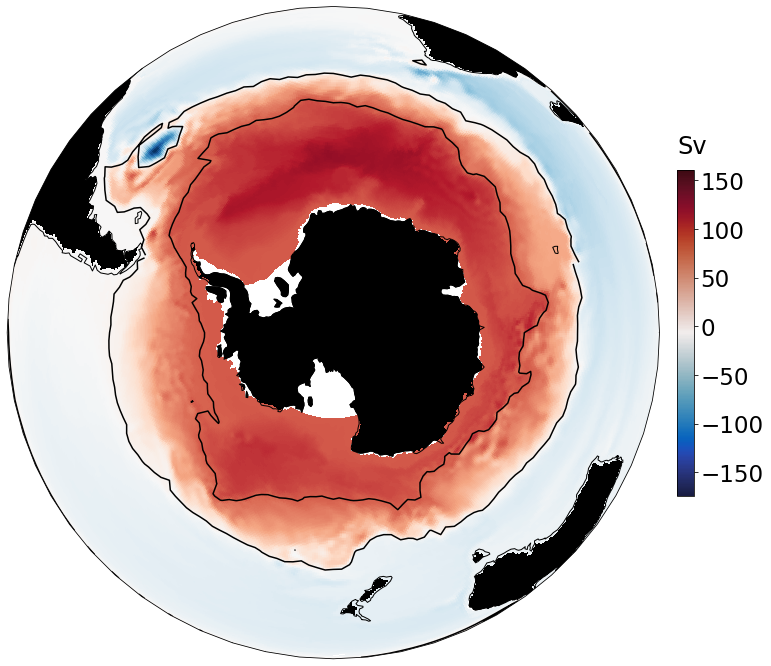

In [60]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})

# map1 = axs.pcolormesh(psi_b_smo.nav_lon,psi_b_smo.nav_lat, psi_b_smo, transform= ccrs.PlateCarree(),
#                      cmap=cm.balance)
b_sf.plot(x='nav_lon', y='nav_lat', transform= ccrs.PlateCarree(), ax=axs, add_colorbar=False)
axs.contour(psi_b_smo.nav_lon,psi_b_smo.nav_lat, psi_b_smo, transform= ccrs.PlateCarree(),
            colors='k',
            levels=[5, 110], linewidth=15, zorder=7)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('Sv', loc='left', fontsize=24, y=1.03)
c.ax.tick_params(labelsize=23)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
plt.savefig(savepath + 'bar_sf_maps_ORION10_mask.png', format='png', facecolor="w", bbox_inches='tight')

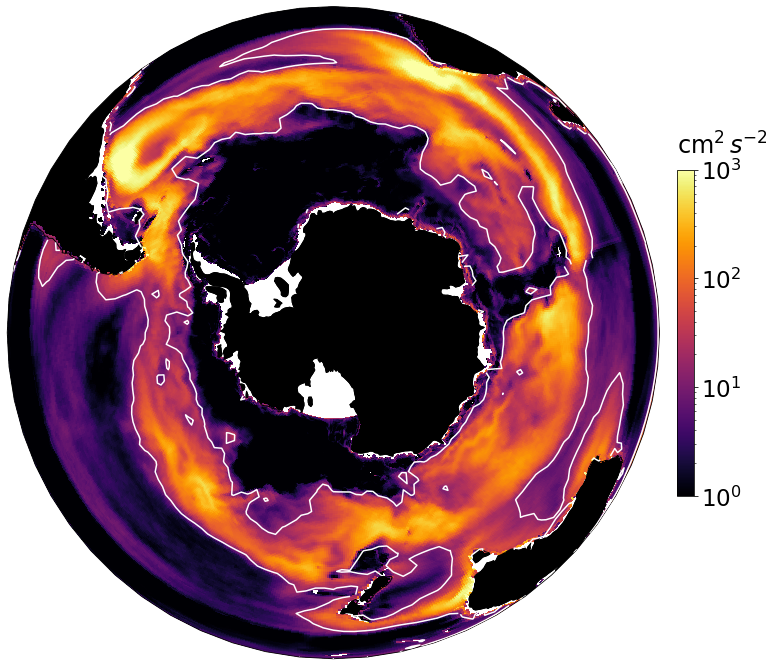

In [67]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})

map1 = (eke_b_m* 1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False, norm=colors.LogNorm(vmin=1e-0, vmax=1000), #vmax=(eke_1_m * 1e4).max().values),
                               cmap = 'inferno')
axs.contour(psi_b_smo.nav_lon,psi_b_smo.nav_lat, 
            (eke_b_smo * 1e4), 
            transform= ccrs.PlateCarree(),
            colors='white',
            levels=[15], linewidth=15, zorder=7)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=24, y=1.03)
c.ax.tick_params(labelsize=23)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
plt.savefig(savepath + 'EKE_maps_ORION10_mask.png', format='png', facecolor="w", bbox_inches='tight')

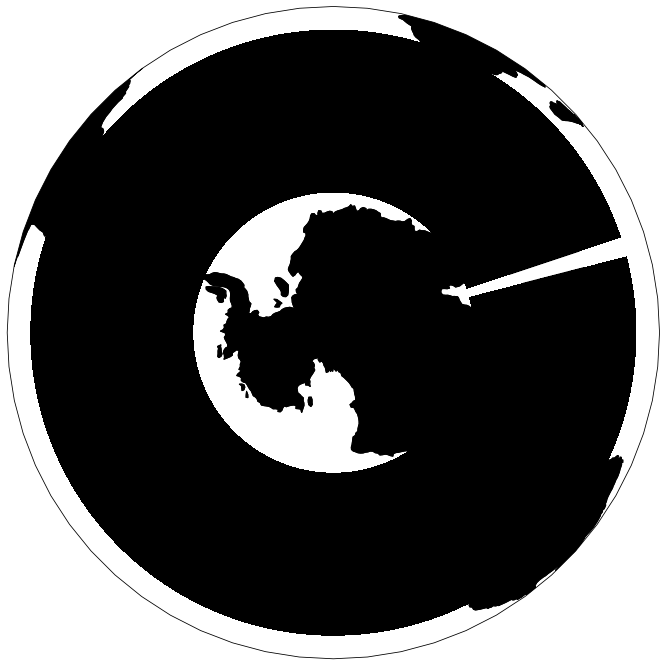

In [74]:
fig, axs = plt.subplots(figsize=(16,12), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})

# map1 = (eke_b_m* 1e4).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
#                                add_colorbar= False, norm=colors.LogNorm(vmin=1e-0, vmax=1000), #vmax=(eke_1_m * 1e4).max().values),
#                                cmap = 'inferno')
axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='k', levels=[1], linewidth=15, zorder=7)

mask_plot.where(mask_plot).plot(x='nav_lon', y='nav_klat'transform= ccrs.PlateCarree())
axs.contourf(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot.where, transform= ccrs.PlateCarree(),
            colors='k', levels=[0, 1], linewidth=15, zorder=6)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
# c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
# c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=24, y=1.03)
# c.ax.tick_params(labelsize=23)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
# plt.savefig(savepath + 'ORION10_mask.png', format='png', facecolor="w", bbox_inches='tight')

In [75]:
mask_plot

<xarray.DataArray 'mask_nest' (y: 627, x: 3562)>
dask.array<where, shape=(627, 3562), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    nav_lon  (y, x) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    nav_lat  (y, x) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
Dimensions without coordinates: y, x

In [69]:
mask_plot = mask_acc.mask_nest.where(mask_acc.mask_nest ==0, other=1)

mask_plot = mask_plot.where(mask_plot.nav_lat >= -65, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon > 75.5, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon < 431.58, other=0)

In [364]:
lon_b_sm = np.hstack((np.arange(74,181,2), np.arange(-178,75,2)))

In [366]:
lon_b_sm.shape

(181,)

In [468]:
mask_eke = eke_b_smo.copy()

mask_eke.coords['lon_base'] = ('x', lon_b_sm)

mask_eke = mask_eke.where(np.isnan(mask_eke), other=1)

In [338]:
# mask_eke.coords['lon'] = ('x', lon_b_sm)

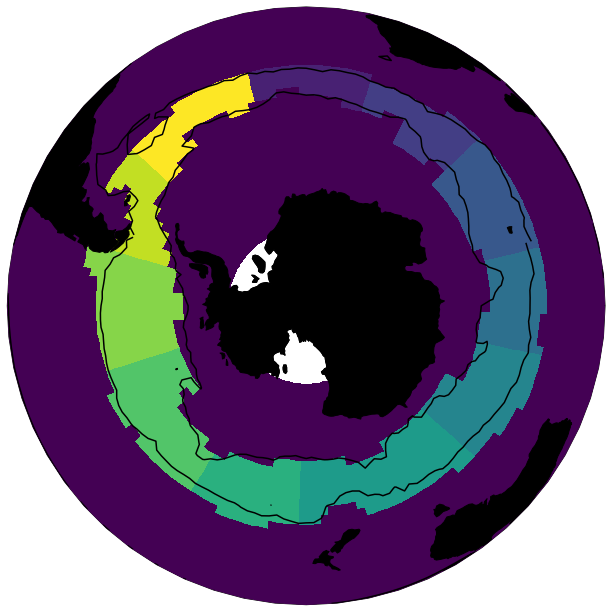

In [556]:
fig, axs = plt.subplots(figsize=(20,11), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
# map1 = ((eke_b_smo * 1e4).where(mask_eke)
#              ).plot(x='nav_lon', y='nav_lat', transform= ccrs.PlateCarree(), add_colorbar=False, ax=axs, zorder=5,
#                     norm = colors.LogNorm(vmin=1e-1, vmax=1e3), 
#                     cmap= 'inferno')

mask_eke.where(mask_eke ).plot(x='nav_lon', y='nav_lat', transform= ccrs.PlateCarree(), add_colorbar=False, ax=axs, zorder=5)

axs.contour(psi_b_smo.nav_lon,psi_b_smo.nav_lat, psi_b_smo, transform= ccrs.PlateCarree(),
            colors='k', levels=[5, 110], linewidth=5, zorder=7)

axs.set_global()
axs.coastlines(zorder=2)
axs.add_feature(cfeature.LAND, zorder=7, color='k')

gl = axs.gridlines(color='gray', alpha=0.5, transform= ccrs.PlateCarree(), zorder=0)
gl.xlines = False
gl.ylocator = mticker.FixedLocator([-65, -37])

# c = plt.colorbar(map1, pad=0.02, shrink=0.7, ax=axs)
# c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
plt.savefig(save_path + 'mask_smooth_2d.png', format='png', facecolor="w",  bbox_inches='tight')

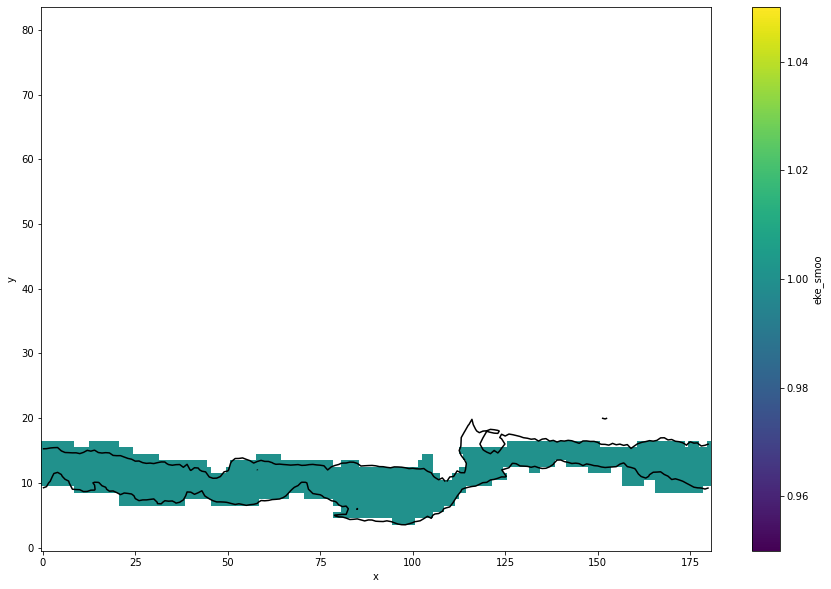

In [520]:
mask_eke.plot(figsize=(15,10))
psi_b_smo.where(psi_b_smo.nav_lat < -35).plot.contour(levels=[5, 110], colors='k')

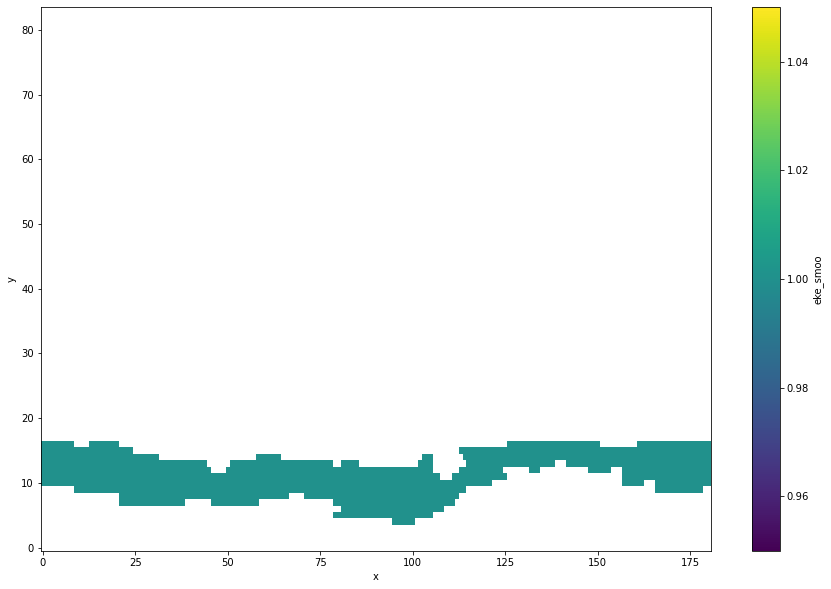

In [526]:
mask_eke.where(((eke_b_smo.nav_lon >= 408) & (eke_b_smo.nav_lon <= 432) 
                & (mask_eke.nav_lat >= -46) & (mask_eke.nav_lat <=-45))==False, other = 1).plot(figsize=(15,10))

Object `toc` not found.


In [527]:
mask_eke = mask_eke.where((psi_b_smo > 5) & (psi_b_smo < 110) | ((eke_b_smo * 1e4) > 15), other=np.nan) #criteria for areas

mask_eke = mask_eke.where((eke_b_smo.nav_lat < -37), other=np.nan) #taking out everything north of -37

mask_eke = mask_eke.where(((eke_b_smo.nav_lon > 321) 
                & (eke_b_smo.nav_lon < 451) 
                & (eke_b_smo.nav_lat < -30) 
                & (eke_b_smo.nav_lat > -50)
                & (psi_b_smo<5))==False, other=np.nan) #south of africa

mask_eke = mask_eke.where(((eke_b_smo.nav_lon > 101) 
                & (eke_b_smo.nav_lon < 191) 
                & (eke_b_smo.nav_lat < -36) 
                & (eke_b_smo.nav_lat > -44))==False, other=np.nan) #retirando australia 

mask_eke = mask_eke.where(((eke_b_smo.nav_lon > 131) 
                & (eke_b_smo.nav_lon < 193) 
                & (eke_b_smo.nav_lat < -36) 
                & (eke_b_smo.nav_lat > -48))==False, other=np.nan) #retirando australia e nz

mask_eke = mask_eke.where(((eke_b_smo.nav_lon > 136) 
                & (eke_b_smo.nav_lon < 189) 
                & (eke_b_smo.nav_lat < -36) 
                & (eke_b_smo.nav_lat > -50))==False, other=np.nan) #retirando australia e nz (finishing)

mask_eke = mask_eke.where(((eke_b_smo.nav_lon > 321) 
                & (eke_b_smo.nav_lon < 451) 
                & (eke_b_smo.nav_lat < -62) 
                & (eke_b_smo.nav_lat > -90))==False, other=np.nan) #cut south of the area lavinia wanted bigger; east of africa

mask_eke = mask_eke.where(((eke_b_smo.nav_lon > 251) 
                & (eke_b_smo.nav_lon < 333) 
                & (eke_b_smo.nav_lat < -38) 
                & (eke_b_smo.nav_lat > -45))==False, other=np.nan) #malvinas

mask_eke = mask_eke.where(((eke_b_smo.nav_lon > 251) 
                & (eke_b_smo.nav_lon < 326) 
                & (eke_b_smo.nav_lat < -35) 
                & (eke_b_smo.nav_lat > -47))==False, other=np.nan) # malvinas, recirculation

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 76) & (eke_b_smo.nav_lon <= 114) 
                & (mask_eke.nav_lat >= -80) & (mask_eke.nav_lat <=-58)
              & (psi_b_smo>110)
               )==False, other = np.nan) #em baixo da australia, perto da antartica

mask_eke = mask_eke.where(((mask_eke.nav_lon >= 221) & (mask_eke.nav_lon <= 228) & (mask_eke.nav_lat >= -70) & (mask_eke.nav_lat <=-63)
               ) == False, other = np.nan) # aquele j quase no ross sea

mask_eke = mask_eke.where(((mask_eke.nav_lon >= 230) & (mask_eke.nav_lon <= 236) & (mask_eke.nav_lat >= -75) & (mask_eke.nav_lat <=-70)
               ) == False, other = np.nan) # pertinho do jota

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 100) & (eke_b_smo.nav_lon <= 114) 
                & (mask_eke.nav_lat >= -60) & (mask_eke.nav_lat <=-55))==False, other = 1) #taking out hole south of australia

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 200) & (eke_b_smo.nav_lon <= 224) 
                & (mask_eke.nav_lat >= -59) & (mask_eke.nav_lat <=-55))==False, other = 1) #buraquinho entre aus e africa

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 150) & (eke_b_smo.nav_lon <= 160) 
                & (mask_eke.nav_lat >= -61) & (mask_eke.nav_lat <=-57))==False, other = 1) #buraquinho pro oeste do de cima

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 78) & (eke_b_smo.nav_lon <= 82) 
                & (mask_eke.nav_lat >= -58) & (mask_eke.nav_lat <=-55))==False, other = 1) # buraco prox do inicio da mask

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 180) & (eke_b_smo.nav_lon <= 189) 
                & (mask_eke.nav_lat >= -68) & (mask_eke.nav_lat <=-65))==False, other = np.nan) #retirar ponta

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 400) & (eke_b_smo.nav_lon <= 429) 
                & (mask_eke.nav_lat >= -64) & (mask_eke.nav_lat <=-60))==False, other = np.nan) #retirar pontas

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 388) & (eke_b_smo.nav_lon <= 404) 
                & (mask_eke.nav_lat >= -64) & (mask_eke.nav_lat <=-58))==False, other = np.nan) #retirar ponta

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 378) & (eke_b_smo.nav_lon <= 388) 
                & (mask_eke.nav_lat >= -46) & (mask_eke.nav_lat <=-42))==False, other = np.nan)

mask_eke = mask_eke.where(((eke_b_smo.nav_lon >= 408) & (eke_b_smo.nav_lon <= 432) 
                & (mask_eke.nav_lat >= -46) & (mask_eke.nav_lat <=-45))==False, other = 1) # buraco

In [390]:
# mask_eke = mask_eke.where(((eke_b_m.nav_lon > 360) 
#                 & (eke_b_m.nav_lon < 450) 
#                 & (eke_b_m.nav_lat < -30) 
#                 & (eke_b_m.nav_lat > -50)
#                 & (b_sf<5))==False, other=np.nan) #south of africa, taking out north of b streamfunction lines

In [391]:
# mask_eke = mask_eke.where(((eke_b_m.nav_lon > 360) 
#                 & (eke_b_m.nav_lon < 450) 
#                 & (eke_b_m.nav_lat < -30) 
#                 & (eke_b_m.nav_lat > -42))==False, other=np.nan)

In [393]:
# mask_eke = mask_eke.where(((eke_b_m.nav_lon > 150) 
#                 & (eke_b_m.nav_lon < 350) 
#                 & (eke_b_m.nav_lat < -70) 
#                 & (eke_b_m.nav_lat > -90))==False, other=np.nan)

In [394]:
# mask_eke = mask_eke.where(((eke_b_m.nav_lon > 0) 
#                 & (eke_b_m.nav_lon < 150) 
#                 & (eke_b_m.nav_lat < -65) 
#                 & (eke_b_m.nav_lat > -90))==False, other=np.nan)

In [395]:
# mask_eke = mask_eke.where(((eke_b_m.nav_lon > 280) 
#                 & (eke_b_m.nav_lon < 290) 
#                 & (eke_b_m.nav_lat < -35) 
#                 & (eke_b_m.nav_lat > -49))==False, other=np.nan)

In [396]:
# mask_eke = mask_eke.where(((eke_b_m.nav_lon > 340) 
#                 & (eke_b_m.nav_lon < 370) 
#                 & (eke_b_m.nav_lat < -35) 
#                 & (eke_b_m.nav_lat > -40))==False, other=np.nan)

In [400]:
# mask_eke = mask_eke.where(((mask_eke.lon >= -68) & (mask_eke.lon <= -62) & (mask_eke.nav_lat >= -50) & (mask_eke.nav_lat <=-40)
#                ) == False, other= np.nan) #little point east of south american coast

In [401]:
# mask_eke = mask_eke.where(((mask_eke.nav_lat <= -65)) == False, other=np.nan)

In [107]:
# mask_eke = mask_eke.where(((mask_eke.lon >= 80) & (mask_eke.lon <= 120) & (mask_eke.nav_lat >= -65) & (mask_eke.nav_lat <=-37)
#               & (b_sf<110)) == False, other=np.nan)

In [ ]:
# mask_eke.where(((mask_eke.nav_lat <= -65)
#               #& (b_sf>110)
#                ) == False
#               ).plot(figsize=(20,10))

In [ ]:
# mask_eke.where((mask_eke.lon >= -50) & (mask_eke.lon <= -15) & (mask_eke.nav_lat >= -65) & (mask_eke.nav_lat <=-37)).plot(figsize=(15,7))

In [529]:
# mask according to Patara 2016
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= -15) & (mask_eke.lon_base <= 15) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 1) # Region 1
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= 15) & (mask_eke.lon_base <= 45) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 2) # Region 2
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= 45) & (mask_eke.lon_base <= 75) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 3) # Region 3
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= 75) & (mask_eke.lon_base <= 100) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 4) # Region 4
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= 100) & (mask_eke.lon_base <= 130) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 5) # Region 5
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= 130) & (mask_eke.lon_base <= 180) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 6) # Region 6
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= -180) & (mask_eke.lon_base <= -150) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 7) # Region 7
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= -150) & (mask_eke.lon_base <= -110) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 8) # Region 8
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= -110) & (mask_eke.lon_base <= -76) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 9) # Region 9
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= -76) & (mask_eke.lon_base <= -50) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 10) # Region 10
mask_eke = mask_eke.where(((mask_eke==1) & (mask_eke.lon_base >= -50) & (mask_eke.lon_base <= -15) 
#                            & (mask_eke.nav_lat >= -65) 
                           & (mask_eke.nav_lat <=-37)) == False, other = 11) # Region 11

In [530]:
mask_eke = mask_eke.where((np.isnan(mask_eke)==False), other=0) # do at the end --> nan to zeros

In [273]:
mask_eke = mask_eke.where((mask_eke)==1, other=np.nan) #back to nan values 

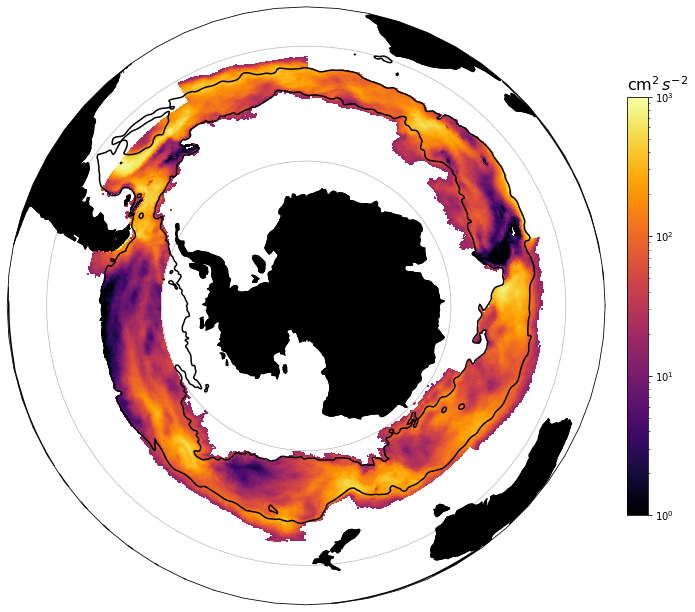

In [404]:
fig, axs = plt.subplots(figsize=(20,11), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
map1 = ((eke_b_m * 1e4).where(mask_eke)
             ).plot(x='nav_lon', y='nav_lat', transform= ccrs.PlateCarree(), add_colorbar=False, ax=axs, zorder=5,
                    norm = colors.LogNorm(vmin=1e0, vmax=1e3), 
                    cmap= 'inferno')

axs.contour(b_sf.nav_lon,b_sf.nav_lat, b_sf, transform= ccrs.PlateCarree(),
            colors='k', levels=[5, 110], linewidth=5, zorder=7)

axs.set_global()
axs.coastlines(zorder=2)
axs.add_feature(cfeature.LAND, zorder=3, color='k')

gl = axs.gridlines(color='gray', alpha=0.5, transform= ccrs.PlateCarree(), zorder=0)
gl.xlines = False
gl.ylocator = mticker.FixedLocator([-65, -37])

c = plt.colorbar(map1, pad=0.02, shrink=0.7, ax=axs)
c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
plt.savefig(save_path + 'mask_15cm2s2.png', format='png', facecolor="w",  bbox_inches='tight')

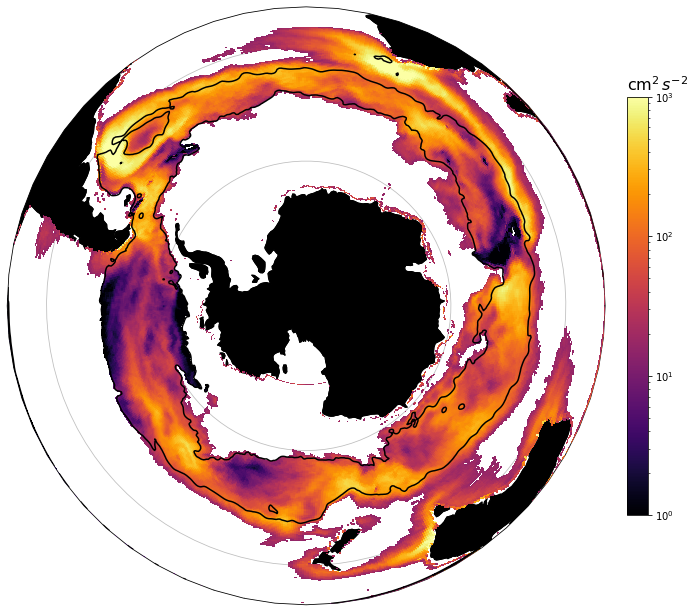

In [284]:
fig, axs = plt.subplots(figsize=(20,11), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
map1 = ((eke_b_m * 1e4).where((b_sf > 5) & (b_sf < 110) | ((eke_b_m * 1e4) > 15))
             ).plot(x='nav_lon', y='nav_lat', transform= ccrs.PlateCarree(), add_colorbar=False, ax=axs, zorder=5,
                    norm = colors.LogNorm(vmin=1e0, vmax=1e3), 
                    cmap= 'inferno')

axs.contour(b_sf.nav_lon,b_sf.nav_lat, b_sf, transform= ccrs.PlateCarree(),
            colors='k', levels=[5, 110], linewidth=5, zorder=7)

axs.set_global()
axs.coastlines(zorder=2)
axs.add_feature(cfeature.LAND, zorder=3, color='k')

gl = axs.gridlines(color='gray', alpha=0.5, transform= ccrs.PlateCarree(), zorder=0)
gl.xlines = False
gl.ylocator = mticker.FixedLocator([-65, -37])

c = plt.colorbar(map1, pad=0.02, shrink=0.7, ax=axs)
c.ax.set_title('cm$^{2}\,s^{-2}$', loc='left', fontsize=16)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
# plt.savefig(save_path + 'EKE_base_bsf_inf.png', format='png', facecolor="w",  bbox_inches='tight')

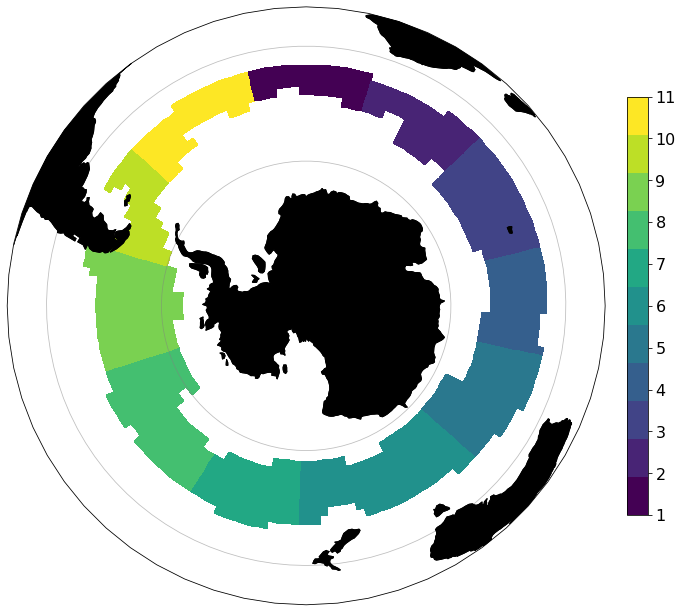

In [547]:
fig, axs = plt.subplots(figsize=(20,11), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})

map1 = mask_eke.where(mask_eke != 0).plot(x='nav_lon',y='nav_lat', transform = ccrs.PlateCarree(), ax=axs,
             cmap = plt.cm.get_cmap('viridis', 11), add_colorbar=False, zorder=0)
axs.coastlines(zorder=1)
axs.add_feature(cfeature.LAND, zorder=2, color='k')

c = plt.colorbar(map1, pad=0.02, shrink=0.7, ax=axs)

c.set_ticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
c.ax.tick_params(labelsize=16)

gl = axs.gridlines(color='gray', alpha=0.5, transform= ccrs.PlateCarree(), zorder=0)
gl.xlines = False
gl.ylocator = mticker.FixedLocator([-65, -37])


# c.set_ticklabels(['ICE', 'SPSS', 'STSS'])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
# plt.savefig(save_path + 'mask_base_2d.png', format='png', facecolor="w",  bbox_inches='tight')

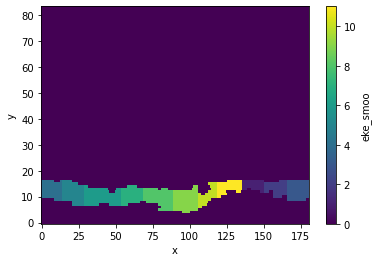

In [534]:
mask_eke.plot()

In [ ]:
eke_1_m.nav_lon.min()

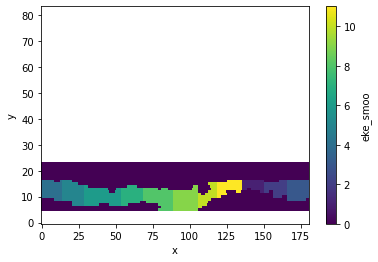

In [535]:
mask_eke.where((mask_eke.nav_lat <= eke_1_m.nav_lat.max()) & (mask_eke.nav_lat >= eke_1_m.nav_lat.min())).plot()

In [536]:
#cutting the latitudes to be approx the same as in the nest
mask_eke_cut = mask_eke.where((mask_eke.nav_lat <= eke_1_m.nav_lat.max()) & (mask_eke.nav_lat >= eke_1_m.nav_lat.min()), drop=True)

In [537]:
#cutting the longitudes to be approx the same as in the nest
mask_eke_cut = mask_eke_cut.where((mask_eke_cut.nav_lon <= eke_1_m.nav_lon.max()) & (mask_eke_cut.nav_lon >= eke_1_m.nav_lon.min()), drop=True)

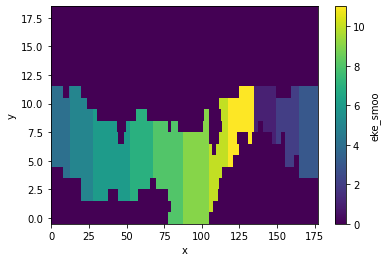

In [538]:
mask_eke_cut.plot()

In [ ]:
mask_eke_cut

In [ ]:
eke_1_m

In [ ]:
fig, axs = plt.subplots(
    figsize=(15,7),
    subplot_kw={'projection': cartopy.crs.NearsidePerspective(central_latitude=-90)}
)

axs.contourf(
    ds.longitude, ds.latitude,
    ds.z.isel(level=0, month=0),
    transform=cartopy.crs.PlateCarree(),
    levels=[110000, 111000, 111100, 111600, 112000], 
)

axs.coastlines()
axs.add_feature(cartopy.feature.LAND)

In [539]:
interp = NearestNDInterpolator(list(zip(mask_eke_cut.nav_lon.values.flatten(), mask_eke_cut.nav_lat.values.flatten())), mask_eke_cut.values.flatten())

In [540]:
Z = interp(eke_1_m.nav_lon.values, eke_1_m.nav_lat.values)

In [73]:
Z

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

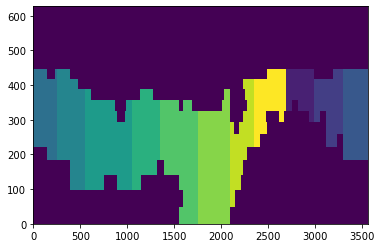

In [541]:
plt.pcolor(Z)

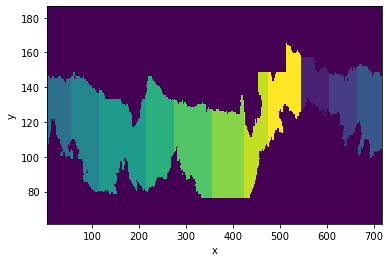

In [71]:
mask_eke_cut.plot(add_colorbar=False)

In [61]:
print(mask_eke_cut.x.values.shape)
print(mask_eke_cut.y.values.shape)
print(mask_eke_cut.values.shape)

(713,)
(125,)
(125, 713)


In [62]:
print(eke_1_m.nav_lat.values.shape)
print(eke_1_m.nav_lon.values.shape)

(627, 3562)
(627, 3562)


In [ ]:
eke_1_m

In [542]:
mask_n_int = xr.Dataset(
    data_vars=dict(
        mask_nest=(['y','x'], Z)),
    coords=dict(
        nav_lon=(['y','x'], eke_1_m.coords['nav_lon'].values),
        nav_lat=(['y','x'], eke_1_m.coords['nav_lat'].values)))

mask_int = mask_n_int.mask_nest

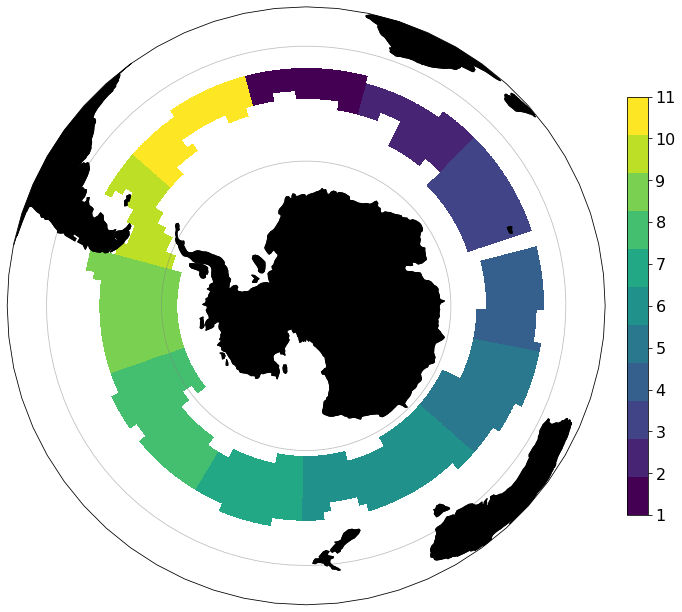

In [548]:
fig, axs = plt.subplots(figsize=(20,11), subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})

map1 = mask_int.where(mask_int != 0).plot(x='nav_lon',y='nav_lat', transform = ccrs.PlateCarree(), ax=axs,
             cmap = plt.cm.get_cmap('viridis', 11), add_colorbar=False, zorder=0)

axs.set_global()
axs.coastlines(zorder=1)
axs.add_feature(cfeature.LAND, zorder=2, color='k')

c = plt.colorbar(map1, pad=0.02, shrink=0.7, ax=axs)

c.set_ticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
c.ax.tick_params(labelsize=16)

gl = axs.gridlines(color='gray', alpha=0.5, transform= ccrs.PlateCarree(), zorder=0)
gl.xlines = False
gl.ylocator = mticker.FixedLocator([-65, -37])

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
# plt.savefig(save_path + 'mask_nest_2d.png', format='png', facecolor="w",  bbox_inches='tight')

### Calculating the weighted mean

In [549]:
def weighted_mean(variable, weight, a):#, mask): DIFFERENT VERSION
    variable = variable.where(mask_int == a)
    weight = weight.where(mask_int == a)
    return (variable * weight).sum(('x','y')) / weight.sum(('x','y'))

In [550]:
e1t = xr.open_dataset(glob(mask_path + '1_mesh_mask.nc')[0], chunks={"z":46, "y":100, "x":100}).e1t.isel(x=slice(1,-1), y=slice(1,-1)).squeeze()
e2t = xr.open_dataset(glob(mask_path + '1_mesh_mask.nc')[0], chunks={"z":46, "y":100, "x":100}).e2t.isel(x=slice(1,-1), y=slice(1,-1)).squeeze()

In [551]:
area = (e1t * e2t)

In [552]:
eke_m_a1 = weighted_mean(eke_1, area, a=1).compute()

eke_m_a2 = weighted_mean(eke_1, area, a=2).compute()
eke_m_a3 = weighted_mean(eke_1, area, a=3).compute()
eke_m_a4 = weighted_mean(eke_1, area, a=4).compute()
eke_m_a5 = weighted_mean(eke_1, area, a=5).compute()
eke_m_a6 = weighted_mean(eke_1, area, a=6).compute()
eke_m_a7 = weighted_mean(eke_1, area, a=7).compute()
eke_m_a8 = weighted_mean(eke_1, area, a=8).compute()
eke_m_a9 = weighted_mean(eke_1, area, a=9).compute()
eke_m_a10 = weighted_mean(eke_1, area, a=10).compute()
eke_m_a11 = weighted_mean(eke_1, area, a=11).compute()

In [553]:
eke_evo_regions = eke_m_a1.to_dataset(name = 'eke_m_r1')

eke_evo_regions['eke_m_r2'] = eke_m_a2
eke_evo_regions['eke_m_r3'] = eke_m_a3
eke_evo_regions['eke_m_r4'] = eke_m_a4
eke_evo_regions['eke_m_r5'] = eke_m_a5
eke_evo_regions['eke_m_r6'] = eke_m_a6
eke_evo_regions['eke_m_r7'] = eke_m_a7
eke_evo_regions['eke_m_r8'] = eke_m_a8
eke_evo_regions['eke_m_r9'] = eke_m_a9
eke_evo_regions['eke_m_r10'] = eke_m_a10
eke_evo_regions['eke_m_r11'] = eke_m_a11

In [215]:
path_eke_nest

'/scratch/usr/shkifmmp/master/data/ORION10/EKE/nest/'

In [216]:
# eke_evo_regions.to_netcdf(path = path_eke_nest + 'timeseries_eke_regions.nc', mode = 'w')

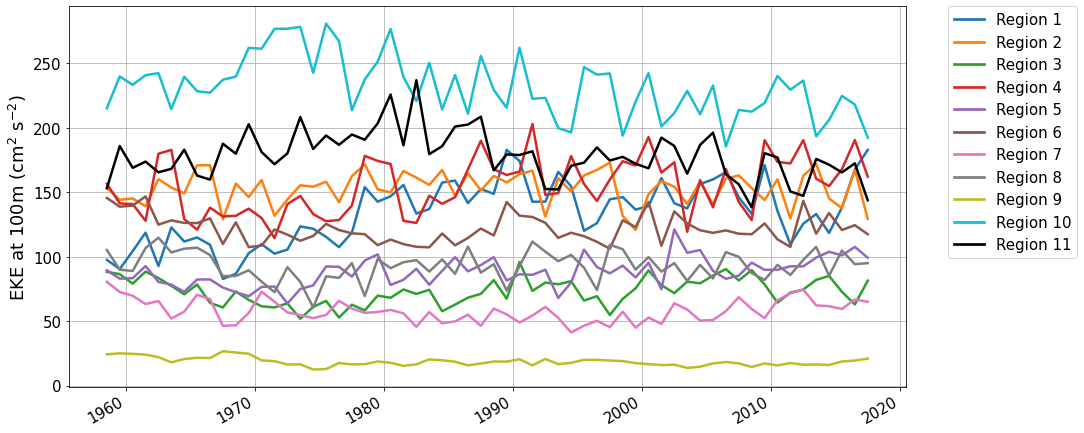

In [555]:
fig, axs = plt.subplots(figsize=(15,7))

(eke_m_a1 * 1e4).plot(ax=axs, label='Region 1', linewidth=2.5)
(eke_m_a2 * 1e4).plot(ax=axs, label='Region 2', linewidth=2.5)
(eke_m_a3 * 1e4).plot(ax=axs, label='Region 3', linewidth=2.5)
(eke_m_a4 * 1e4).plot(ax=axs, label='Region 4', linewidth=2.5)
(eke_m_a5 * 1e4).plot(ax=axs, label='Region 5', linewidth=2.5)
(eke_m_a6 * 1e4).plot(ax=axs, label='Region 6', linewidth=2.5)
(eke_m_a7 * 1e4).plot(ax=axs, label='Region 7', linewidth=2.5)
(eke_m_a8 * 1e4).plot(ax=axs, label='Region 8', linewidth=2.5)
(eke_m_a9 * 1e4).plot(ax=axs, label='Region 9', linewidth=2.5)
(eke_m_a10 * 1e4).plot(ax=axs, label='Region 10', linewidth=2.5)
(eke_m_a11 * 1e4).plot(ax=axs, label='Region 11', linewidth=2.5, color='black')

leg = axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=15)
for line in leg.get_lines():
        line.set_linewidth(2.7)

axs.grid()
axs.set_xlabel(None)
axs.yaxis.set_tick_params(labelsize = 15)
axs.xaxis.set_tick_params(labelsize = 15)
axs.set_ylabel('EKE at 100m (cm$^{2}$ s$^{-2}$)', fontsize=18)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/master/figures/'
plt.savefig(save_path + 'eke_mean_regions.png', format='png', facecolor="w",  bbox_inches='tight')

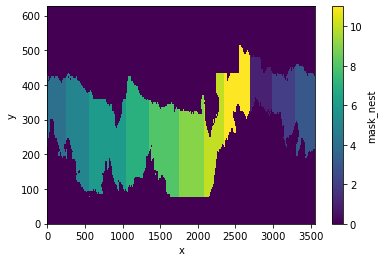

In [107]:
mask_int.plot()

In [545]:
mask_int.to_netcdf(path = mask_path + 'mask_nest_int_2d.nc', mode = 'w')

In [546]:
mask_eke.to_netcdf(path = mask_path + 'mask_base_forint_2d.nc', mode = 'w')

In [202]:
mask_eke.name?

Type:        property
String form: <property object at 0x2aaae03463b0>
Docstring:   The name of this array.
